In [ ]:
!pip install torch torchvision Pillow pandas matplotlib numpy tqdm -q

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import random

In [2]:
TRAIN_CSV = '/train/labels.csv'
TRAIN_IMG_DIR = '/train/images'
VAL_CSV = '/val/labels.csv'
VAL_IMG_DIR = '/val/images'

IMG_HEIGHT = 32
IMG_WIDTH = 128
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-5
DROPOUT = 0.3
EARLY_STOPPING_PATIENCE = 7
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Dropout: {DROPOUT}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")

Using device: cuda
Learning rate: 0.0001
Dropout: 0.3
Early stopping patience: 7


In [3]:
class ResizeWithPad:
    def __init__(self, target_height=32, target_width=128, fill_value=0):
        self.target_height = target_height
        self.target_width = target_width
        self.fill_value = fill_value
    
    def __call__(self, img):
        w, h = img.size
        
        aspect = w / h
        target_aspect = self.target_width / self.target_height
        
        if aspect > target_aspect:
            new_width = self.target_width
            new_height = int(self.target_width / aspect)
        else:
            new_height = self.target_height
            new_width = int(self.target_height * aspect)
        
        img = img.resize((new_width, new_height), Image.LANCZOS)
        
        new_img = Image.new('L', (self.target_width, self.target_height), self.fill_value)
        
        paste_x = (self.target_width - new_width) // 2
        paste_y = (self.target_height - new_height) // 2
        new_img.paste(img, (paste_x, paste_y))
        
        return new_img

In [4]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

if len(train_df) < 500:
    print(f"\n⚠️ WARNING: Small dataset ({len(train_df)} samples). Strong augmentation recommended!")

print(f"\nSample data:")
print(train_df.head())

Train samples: 21532
Val samples: 2692

Sample data:
                          filename plate_number
0    img55067_plate_1_conf0.78.jpg    77-QF-603
1  img_v2_022_plate_1_conf0.77.jpg    77 MH 382
2    img40589_plate_1_conf0.77.jpg    77-QD-729
3     img8150_plate_1_conf0.78.jpg    77-EZ-218
4     img4526_plate_1_conf0.71.jpg      99FY435


In [5]:
sample_sizes = []
for i in range(min(50, len(train_df))):
    img_path = os.path.join(TRAIN_IMG_DIR, train_df.iloc[i]['filename'])
    img = Image.open(img_path)
    sample_sizes.append(img.size)

widths = [s[0] for s in sample_sizes]
heights = [s[1] for s in sample_sizes]
aspects = [w/h for w, h in sample_sizes]

print(f"Image size statistics (sample of {len(sample_sizes)} images):")
print(f"Width:  min={min(widths)}, max={max(widths)}, avg={sum(widths)/len(widths):.1f}")
print(f"Height: min={min(heights)}, max={max(heights)}, avg={sum(heights)/len(heights):.1f}")
print(f"Aspect ratio: min={min(aspects):.2f}, max={max(aspects):.2f}, avg={sum(aspects)/len(aspects):.2f}")
print(f"Target aspect ratio: {IMG_WIDTH/IMG_HEIGHT:.2f}")

Image size statistics (sample of 50 images):
Width:  min=35, max=167, avg=89.8
Height: min=9, max=67, avg=27.3
Aspect ratio: min=1.12, max=4.70, avg=3.40
Target aspect ratio: 4.00


In [6]:
all_chars = set()
for plate in train_df['plate_number']:
    all_chars.update(str(plate))
for plate in val_df['plate_number']:
    all_chars.update(str(plate))

CHARS = sorted(list(all_chars))
BLANK_LABEL = len(CHARS)
NUM_CLASSES = len(CHARS) + 1

char_to_idx = {char: idx for idx, char in enumerate(CHARS)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

print(f"Total unique characters: {len(CHARS)}")
print(f"Characters: {''.join(CHARS)}")
print(f"Number of classes (with blank): {NUM_CLASSES}")

Total unique characters: 65
Characters:  -.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZadefino·ÖÜüВГКМОРСТУмсхน모오
Number of classes (with blank): 66


In [7]:
class LicensePlateDataset(Dataset):
    def __init__(self, csv_file, img_dir, char_to_idx, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.char_to_idx = char_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]['filename'])
        image = Image.open(img_name).convert('L')
        label = str(self.data.iloc[idx]['plate_number'])
        
        if self.transform:
            image = self.transform(image)
        
        label_encoded = [self.char_to_idx[char] for char in label]
        label_length = len(label_encoded)
        
        return image, torch.LongTensor(label_encoded), label_length

In [8]:
train_transform = transforms.Compose([
    ResizeWithPad(IMG_HEIGHT, IMG_WIDTH),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    ResizeWithPad(IMG_HEIGHT, IMG_WIDTH),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = LicensePlateDataset(TRAIN_CSV, TRAIN_IMG_DIR, char_to_idx, transform=train_transform)
val_dataset = LicensePlateDataset(VAL_CSV, VAL_IMG_DIR, char_to_idx, transform=val_transform)

def collate_fn(batch):
    images, labels, label_lengths = zip(*batch)
    images = torch.stack(images, 0)
    labels = torch.cat(labels, 0)
    label_lengths = torch.LongTensor(label_lengths)
    return images, labels, label_lengths

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"\n✅ Data augmentation enabled for training set")
print(f"Augmentations: Rotation, ColorJitter, Affine, GaussianBlur")

Train batches: 337
Val batches: 43

✅ Data augmentation enabled for training set
Augmentations: Rotation, ColorJitter, Affine, GaussianBlur


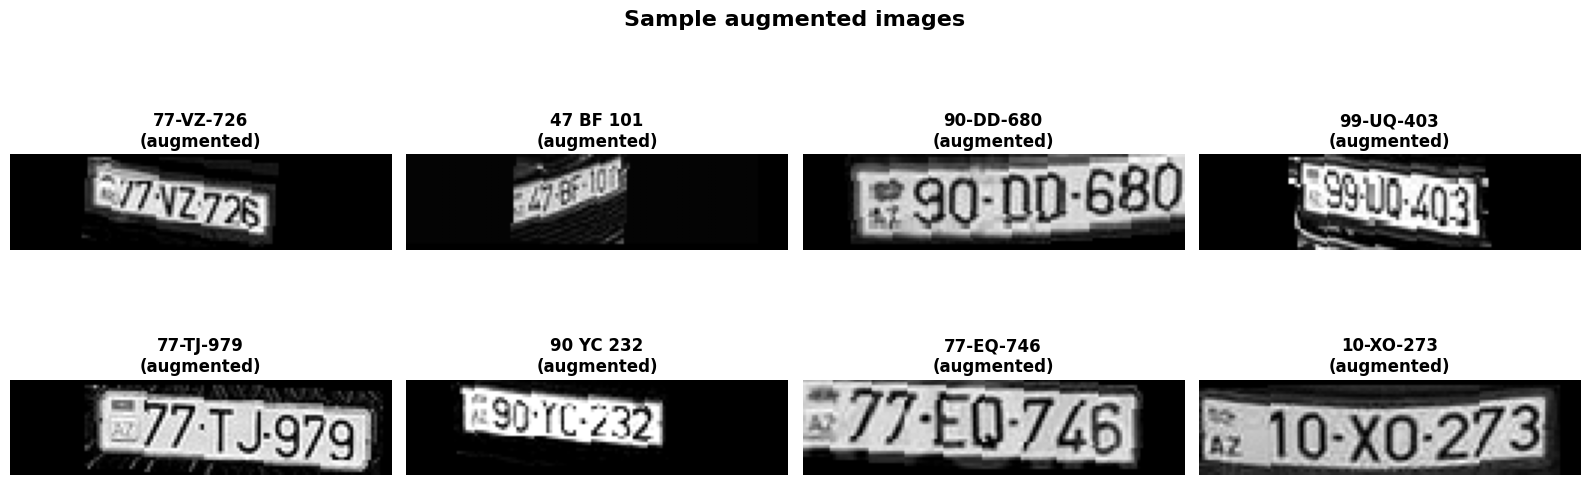

In [9]:
sample_batch = next(iter(train_loader))
images, labels, label_lengths = sample_batch

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze().numpy()
    img = (img * 0.5 + 0.5)
    ax.imshow(img, cmap='gray')
    
    start_idx = sum(label_lengths[:i])
    end_idx = start_idx + label_lengths[i]
    label_text = ''.join([idx_to_char[idx.item()] for idx in labels[start_idx:end_idx]])
    
    ax.set_title(f"{label_text}\n(augmented)", fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sample augmented images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
class CRNN(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(CRNN, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout2d(0.3),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1))
        )
        
        self.rnn = nn.LSTM(512 * 2, 256, bidirectional=True, num_layers=2, batch_first=True, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        
        batch, channels, height, width = x.size()
        x = x.reshape(batch, channels * height, width)
        x = x.permute(0, 2, 1)
        
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.classifier(x)
        
        x = x.permute(1, 0, 2)
        x = nn.functional.log_softmax(x, dim=2)
        
        return x

In [11]:
model = CRNN(num_classes=NUM_CLASSES, dropout=DROPOUT).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\n✅ Model with Dropout={DROPOUT} regularization")
print(f"\nModel architecture:")
print(model)

Total parameters: 8,737,602
Trainable parameters: 8,737,602

✅ Model with Dropout=0.3 regularization

Model architecture:
CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=(2, 1), stride=(2,

In [12]:
criterion = nn.CTCLoss(blank=BLANK_LABEL, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print(f"Optimizer: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay (L2 regularization): {WEIGHT_DECAY}")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

Optimizer: Adam
Learning rate: 0.0001
Weight decay (L2 regularization): 1e-05
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


In [13]:
def decode_predictions(outputs, blank_label):
    outputs = outputs.permute(1, 0, 2)
    _, max_index = torch.max(outputs, dim=2)
    
    decoded = []
    for i in range(max_index.size(0)):
        raw = max_index[i].tolist()
        decoded_seq = []
        prev_char = None
        for char in raw:
            if char != blank_label and char != prev_char:
                decoded_seq.append(char)
            prev_char = char
        decoded.append(decoded_seq)
    
    return decoded

In [14]:
def calculate_accuracy(outputs, labels, label_lengths, blank_label, idx_to_char):
    decoded = decode_predictions(outputs, blank_label)
    
    correct = 0
    total = len(decoded)
    
    label_start = 0
    for i, pred_seq in enumerate(decoded):
        label_end = label_start + label_lengths[i]
        true_seq = labels[label_start:label_end].tolist()
        label_start = label_end
        
        if pred_seq == true_seq:
            correct += 1
    
    return correct / total * 100

In [15]:
def calculate_cer(outputs, labels, label_lengths, blank_label, idx_to_char):
    decoded = decode_predictions(outputs, blank_label)
    
    total_chars = 0
    total_errors = 0
    
    label_start = 0
    for i, pred_seq in enumerate(decoded):
        label_end = label_start + label_lengths[i]
        true_seq = labels[label_start:label_end].tolist()
        label_start = label_end
        
        total_chars += len(true_seq)
        
        errors = sum(1 for p, t in zip(pred_seq, true_seq) if p != t)
        errors += abs(len(pred_seq) - len(true_seq))
        total_errors += errors
    
    return (total_errors / total_chars * 100) if total_chars > 0 else 0

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device, blank_label, idx_to_char):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_cer = 0.0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for images, labels, label_lengths in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        input_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long)
        
        loss = criterion(outputs, labels, input_lengths, label_lengths)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        
        running_loss += loss.item()
        
        with torch.no_grad():
            accuracy = calculate_accuracy(outputs, labels, label_lengths, blank_label, idx_to_char)
            cer = calculate_cer(outputs, labels, label_lengths, blank_label, idx_to_char)
            running_accuracy += accuracy
            running_cer += cer
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{accuracy:.2f}%',
            'cer': f'{cer:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    epoch_cer = running_cer / len(dataloader)
    
    return epoch_loss, epoch_accuracy, epoch_cer

In [17]:
def validate_epoch(model, dataloader, criterion, device, blank_label, idx_to_char):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_cer = 0.0
    
    progress_bar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for images, labels, label_lengths in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            input_lengths = torch.full((images.size(0),), outputs.size(0), dtype=torch.long)
            
            loss = criterion(outputs, labels, input_lengths, label_lengths)
            
            running_loss += loss.item()
            
            accuracy = calculate_accuracy(outputs, labels, label_lengths, blank_label, idx_to_char)
            cer = calculate_cer(outputs, labels, label_lengths, blank_label, idx_to_char)
            running_accuracy += accuracy
            running_cer += cer
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{accuracy:.2f}%',
                'cer': f'{cer:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    epoch_cer = running_cer / len(dataloader)
    
    return epoch_loss, epoch_accuracy, epoch_cer

In [18]:
history = {
    'train_loss': [],
    'train_acc': [],
    'train_cer': [],
    'val_loss': [],
    'val_acc': [],
    'val_cer': [],
    'lr': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

print(f"\n{'='*60}")
print(f"Starting training with early stopping (patience={EARLY_STOPPING_PATIENCE})")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'='*60}")
    
    train_loss, train_acc, train_cer = train_epoch(
        model, train_loader, criterion, optimizer, DEVICE, BLANK_LABEL, idx_to_char
    )
    
    val_loss, val_acc, val_cer = validate_epoch(
        model, val_loader, criterion, DEVICE, BLANK_LABEL, idx_to_char
    )
    
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    if old_lr != new_lr:
        print(f"\n📉 Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_cer'].append(train_cer)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_cer'].append(val_cer)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    print(f"\nEpoch {epoch+1} Results:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train CER: {train_cer:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val CER: {val_cer:.2f}%")
    
    overfitting_gap = train_acc - val_acc
    if overfitting_gap > 10:
        print(f"⚠️ Overfitting detected! Train-Val gap: {overfitting_gap:.2f}%")
    elif overfitting_gap < 5:
        print(f"✅ Good generalization! Train-Val gap: {overfitting_gap:.2f}%")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'char_to_idx': char_to_idx,
            'idx_to_char': idx_to_char,
            'num_classes': NUM_CLASSES,
            'blank_label': BLANK_LABEL
        }, 'best_model_loss.pth')
        print(f"✓ Saved best model (loss)")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'char_to_idx': char_to_idx,
            'idx_to_char': idx_to_char,
            'num_classes': NUM_CLASSES,
            'blank_label': BLANK_LABEL
        }, 'best_model_acc.pth')
        print(f"✓ Saved best model (accuracy)")
    
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n🛑 Early stopping triggered at epoch {epoch+1}")
        print(f"No improvement in validation loss for {EARLY_STOPPING_PATIENCE} epochs")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Total epochs: {len(history['train_loss'])}")
print(f"{'='*60}")


Starting training with early stopping (patience=7)


Epoch 1/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 61.13it/s, loss=2.7847, acc=0.00%, cer=100.00%]



Epoch 1 Results:
Train Loss: 3.3797 | Train Acc: 0.00% | Train CER: 100.56%
Val Loss: 2.7457 | Val Acc: 0.00% | Val CER: 100.00%
✅ Good generalization! Train-Val gap: 0.00%
✓ Saved best model (loss)

Epoch 2/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 43.23it/s, loss=2.7130, acc=0.00%, cer=100.00%]



Epoch 2 Results:
Train Loss: 2.6198 | Train Acc: 0.00% | Train CER: 99.58%
Val Loss: 2.4822 | Val Acc: 0.00% | Val CER: 99.99%
✅ Good generalization! Train-Val gap: 0.00%
✓ Saved best model (loss)

Epoch 3/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 59.05it/s, loss=2.3850, acc=0.00%, cer=73.53%]



Epoch 3 Results:
Train Loss: 2.3759 | Train Acc: 0.00% | Train CER: 85.23%
Val Loss: 2.2063 | Val Acc: 0.00% | Val CER: 76.16%
✅ Good generalization! Train-Val gap: 0.00%
✓ Saved best model (loss)

Epoch 4/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 65.25it/s, loss=2.1339, acc=0.00%, cer=70.59%]



Epoch 4 Results:
Train Loss: 2.1615 | Train Acc: 0.00% | Train CER: 74.59%
Val Loss: 2.0096 | Val Acc: 0.00% | Val CER: 71.39%
✅ Good generalization! Train-Val gap: 0.00%
✓ Saved best model (loss)

Epoch 5/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 36.87it/s, loss=1.9798, acc=0.00%, cer=67.65%]



Epoch 5 Results:
Train Loss: 1.9979 | Train Acc: 0.00% | Train CER: 67.16%
Val Loss: 1.8597 | Val Acc: 0.00% | Val CER: 63.66%
✅ Good generalization! Train-Val gap: 0.00%
✓ Saved best model (loss)

Epoch 6/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 63.84it/s, loss=1.8209, acc=0.00%, cer=64.71%]



Epoch 6 Results:
Train Loss: 1.8468 | Train Acc: 0.00% | Train CER: 62.47%
Val Loss: 1.6852 | Val Acc: 0.00% | Val CER: 58.32%
✅ Good generalization! Train-Val gap: 0.00%
✓ Saved best model (loss)

Epoch 7/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 39.07it/s, loss=1.6611, acc=0.00%, cer=67.65%]



Epoch 7 Results:
Train Loss: 1.7035 | Train Acc: 0.02% | Train CER: 59.67%
Val Loss: 1.5347 | Val Acc: 0.11% | Val CER: 58.18%
✅ Good generalization! Train-Val gap: -0.09%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 8/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 33.05it/s, loss=1.6358, acc=0.00%, cer=61.76%]



Epoch 8 Results:
Train Loss: 1.5686 | Train Acc: 0.10% | Train CER: 57.91%
Val Loss: 1.4339 | Val Acc: 0.11% | Val CER: 58.58%
✅ Good generalization! Train-Val gap: -0.01%
✓ Saved best model (loss)

Epoch 9/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 32.94it/s, loss=1.6153, acc=0.00%, cer=64.71%]



Epoch 9 Results:
Train Loss: 1.4521 | Train Acc: 0.24% | Train CER: 56.66%
Val Loss: 1.3284 | Val Acc: 0.69% | Val CER: 56.33%
✅ Good generalization! Train-Val gap: -0.45%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 10/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 33.37it/s, loss=1.4035, acc=0.00%, cer=55.88%]



Epoch 10 Results:
Train Loss: 1.3428 | Train Acc: 0.61% | Train CER: 54.84%
Val Loss: 1.2042 | Val Acc: 1.38% | Val CER: 54.62%
✅ Good generalization! Train-Val gap: -0.77%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 11/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 33.19it/s, loss=1.2139, acc=0.00%, cer=55.88%]



Epoch 11 Results:
Train Loss: 1.2399 | Train Acc: 1.37% | Train CER: 53.24%
Val Loss: 1.0783 | Val Acc: 3.16% | Val CER: 51.34%
✅ Good generalization! Train-Val gap: -1.79%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 12/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 33.12it/s, loss=1.0705, acc=0.00%, cer=52.94%] 



Epoch 12 Results:
Train Loss: 1.1348 | Train Acc: 3.00% | Train CER: 51.62%
Val Loss: 0.9747 | Val Acc: 6.61% | Val CER: 49.98%
✅ Good generalization! Train-Val gap: -3.61%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 13/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 38.69it/s, loss=1.0643, acc=0.00%, cer=55.88%] 



Epoch 13 Results:
Train Loss: 1.0425 | Train Acc: 4.97% | Train CER: 50.37%
Val Loss: 0.8916 | Val Acc: 10.57% | Val CER: 49.65%
✅ Good generalization! Train-Val gap: -5.61%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 14/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 34.33it/s, loss=1.0706, acc=0.00%, cer=70.59%] 



Epoch 14 Results:
Train Loss: 0.9603 | Train Acc: 8.30% | Train CER: 48.90%
Val Loss: 0.8464 | Val Acc: 14.75% | Val CER: 47.58%
✅ Good generalization! Train-Val gap: -6.46%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 15/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 42.29it/s, loss=0.9253, acc=25.00%, cer=52.94%]



Epoch 15 Results:
Train Loss: 0.8931 | Train Acc: 11.28% | Train CER: 47.51%
Val Loss: 0.7442 | Val Acc: 21.22% | Val CER: 43.67%
✅ Good generalization! Train-Val gap: -9.94%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 16/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 54.04it/s, loss=0.8630, acc=25.00%, cer=35.29%]



Epoch 16 Results:
Train Loss: 0.8293 | Train Acc: 15.05% | Train CER: 45.41%
Val Loss: 0.6814 | Val Acc: 28.20% | Val CER: 38.68%
✅ Good generalization! Train-Val gap: -13.15%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 17/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 40.70it/s, loss=0.8584, acc=25.00%, cer=38.24%]



Epoch 17 Results:
Train Loss: 0.7760 | Train Acc: 19.89% | Train CER: 42.72%
Val Loss: 0.6430 | Val Acc: 33.94% | Val CER: 34.79%
✅ Good generalization! Train-Val gap: -14.05%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 18/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 40.05it/s, loss=0.7876, acc=25.00%, cer=44.12%]



Epoch 18 Results:
Train Loss: 0.7282 | Train Acc: 25.51% | Train CER: 39.34%
Val Loss: 0.6033 | Val Acc: 40.23% | Val CER: 30.99%
✅ Good generalization! Train-Val gap: -14.71%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 19/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 61.95it/s, loss=0.7133, acc=25.00%, cer=41.18%]



Epoch 19 Results:
Train Loss: 0.6806 | Train Acc: 30.95% | Train CER: 35.74%
Val Loss: 0.5679 | Val Acc: 46.62% | Val CER: 26.71%
✅ Good generalization! Train-Val gap: -15.67%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 20/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 44.16it/s, loss=0.7363, acc=25.00%, cer=44.12%]



Epoch 20 Results:
Train Loss: 0.6390 | Train Acc: 36.20% | Train CER: 32.09%
Val Loss: 0.5244 | Val Acc: 52.22% | Val CER: 23.57%
✅ Good generalization! Train-Val gap: -16.01%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 21/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 40.60it/s, loss=0.6597, acc=25.00%, cer=41.18%]



Epoch 21 Results:
Train Loss: 0.6021 | Train Acc: 41.05% | Train CER: 28.75%
Val Loss: 0.4785 | Val Acc: 56.18% | Val CER: 21.62%
✅ Good generalization! Train-Val gap: -15.13%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 22/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 57.04it/s, loss=0.6412, acc=25.00%, cer=41.18%]



Epoch 22 Results:
Train Loss: 0.5720 | Train Acc: 44.90% | Train CER: 26.52%
Val Loss: 0.4607 | Val Acc: 58.87% | Val CER: 19.93%
✅ Good generalization! Train-Val gap: -13.96%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 23/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 53.17it/s, loss=0.6166, acc=25.00%, cer=41.18%]



Epoch 23 Results:
Train Loss: 0.5444 | Train Acc: 48.73% | Train CER: 24.48%
Val Loss: 0.4447 | Val Acc: 61.16% | Val CER: 18.87%
✅ Good generalization! Train-Val gap: -12.43%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 24/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 61.96it/s, loss=0.5800, acc=25.00%, cer=44.12%]



Epoch 24 Results:
Train Loss: 0.5183 | Train Acc: 50.71% | Train CER: 22.94%
Val Loss: 0.4273 | Val Acc: 62.14% | Val CER: 18.05%
✅ Good generalization! Train-Val gap: -11.43%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 25/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 61.59it/s, loss=0.4906, acc=25.00%, cer=35.29%]



Epoch 25 Results:
Train Loss: 0.4988 | Train Acc: 52.88% | Train CER: 21.72%
Val Loss: 0.3995 | Val Acc: 63.66% | Val CER: 17.13%
✅ Good generalization! Train-Val gap: -10.78%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 26/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 45.33it/s, loss=0.5997, acc=25.00%, cer=44.12%]



Epoch 26 Results:
Train Loss: 0.4764 | Train Acc: 55.07% | Train CER: 20.52%
Val Loss: 0.4058 | Val Acc: 64.53% | Val CER: 16.88%
✅ Good generalization! Train-Val gap: -9.47%
Patience: 1/7
✓ Saved best model (accuracy)

Epoch 27/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 62.26it/s, loss=0.4582, acc=50.00%, cer=26.47%]



Epoch 27 Results:
Train Loss: 0.4600 | Train Acc: 56.67% | Train CER: 19.56%
Val Loss: 0.3672 | Val Acc: 67.88% | Val CER: 14.89%
✅ Good generalization! Train-Val gap: -11.21%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 28/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 41.62it/s, loss=0.5614, acc=25.00%, cer=41.18%]



Epoch 28 Results:
Train Loss: 0.4459 | Train Acc: 57.85% | Train CER: 18.78%
Val Loss: 0.3754 | Val Acc: 67.22% | Val CER: 15.38%
✅ Good generalization! Train-Val gap: -9.37%
Patience: 1/7

Epoch 29/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 46.30it/s, loss=0.5390, acc=25.00%, cer=35.29%]



Epoch 29 Results:
Train Loss: 0.4313 | Train Acc: 59.22% | Train CER: 18.21%
Val Loss: 0.3628 | Val Acc: 69.84% | Val CER: 14.12%
✅ Good generalization! Train-Val gap: -10.62%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 30/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 41.71it/s, loss=0.5477, acc=25.00%, cer=41.18%]



Epoch 30 Results:
Train Loss: 0.4157 | Train Acc: 60.16% | Train CER: 17.48%
Val Loss: 0.3525 | Val Acc: 70.13% | Val CER: 14.00%
✅ Good generalization! Train-Val gap: -9.97%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 31/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 40.07it/s, loss=0.4845, acc=25.00%, cer=35.29%]



Epoch 31 Results:
Train Loss: 0.4037 | Train Acc: 61.14% | Train CER: 16.81%
Val Loss: 0.3410 | Val Acc: 70.97% | Val CER: 13.54%
✅ Good generalization! Train-Val gap: -9.83%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 32/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 45.02it/s, loss=0.5236, acc=25.00%, cer=35.29%]



Epoch 32 Results:
Train Loss: 0.3957 | Train Acc: 62.09% | Train CER: 16.48%
Val Loss: 0.3407 | Val Acc: 71.26% | Val CER: 13.17%
✅ Good generalization! Train-Val gap: -9.17%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 33/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:01<00:00, 42.68it/s, loss=0.5774, acc=25.00%, cer=35.29%]



Epoch 33 Results:
Train Loss: 0.3847 | Train Acc: 63.09% | Train CER: 15.93%
Val Loss: 0.3369 | Val Acc: 71.80% | Val CER: 13.14%
✅ Good generalization! Train-Val gap: -8.71%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 34/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 64.83it/s, loss=0.5803, acc=25.00%, cer=32.35%]



Epoch 34 Results:
Train Loss: 0.3779 | Train Acc: 63.32% | Train CER: 15.76%
Val Loss: 0.3462 | Val Acc: 71.95% | Val CER: 12.85%
✅ Good generalization! Train-Val gap: -8.62%
Patience: 1/7
✓ Saved best model (accuracy)

Epoch 35/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 60.87it/s, loss=0.5718, acc=25.00%, cer=32.35%]



Epoch 35 Results:
Train Loss: 0.3679 | Train Acc: 64.38% | Train CER: 15.22%
Val Loss: 0.3246 | Val Acc: 72.17% | Val CER: 12.42%
✅ Good generalization! Train-Val gap: -7.79%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 36/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 43.47it/s, loss=0.5466, acc=25.00%, cer=29.41%]



Epoch 36 Results:
Train Loss: 0.3592 | Train Acc: 64.54% | Train CER: 15.10%
Val Loss: 0.3218 | Val Acc: 73.22% | Val CER: 12.13%
✅ Good generalization! Train-Val gap: -8.68%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 37/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 61.79it/s, loss=0.6104, acc=25.00%, cer=44.12%]



Epoch 37 Results:
Train Loss: 0.3471 | Train Acc: 65.38% | Train CER: 14.53%
Val Loss: 0.3221 | Val Acc: 73.11% | Val CER: 12.50%
✅ Good generalization! Train-Val gap: -7.73%
Patience: 1/7

Epoch 38/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 59.24it/s, loss=0.5892, acc=25.00%, cer=29.41%]



Epoch 38 Results:
Train Loss: 0.3436 | Train Acc: 65.94% | Train CER: 14.26%
Val Loss: 0.3196 | Val Acc: 73.62% | Val CER: 11.77%
✅ Good generalization! Train-Val gap: -7.68%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 39/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 64.29it/s, loss=0.5828, acc=25.00%, cer=41.18%]



Epoch 39 Results:
Train Loss: 0.3348 | Train Acc: 66.88% | Train CER: 13.90%
Val Loss: 0.3210 | Val Acc: 74.27% | Val CER: 12.04%
✅ Good generalization! Train-Val gap: -7.40%
Patience: 1/7
✓ Saved best model (accuracy)

Epoch 40/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 48.54it/s, loss=0.5478, acc=25.00%, cer=29.41%]



Epoch 40 Results:
Train Loss: 0.3303 | Train Acc: 67.15% | Train CER: 13.55%
Val Loss: 0.3105 | Val Acc: 74.89% | Val CER: 11.38%
✅ Good generalization! Train-Val gap: -7.74%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 41/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 56.68it/s, loss=0.5746, acc=25.00%, cer=35.29%]



Epoch 41 Results:
Train Loss: 0.3261 | Train Acc: 67.54% | Train CER: 13.52%
Val Loss: 0.3126 | Val Acc: 75.36% | Val CER: 11.56%
✅ Good generalization! Train-Val gap: -7.82%
Patience: 1/7
✓ Saved best model (accuracy)

Epoch 42/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 43.65it/s, loss=0.5488, acc=50.00%, cer=26.47%]



Epoch 42 Results:
Train Loss: 0.3190 | Train Acc: 68.22% | Train CER: 13.21%
Val Loss: 0.3141 | Val Acc: 75.62% | Val CER: 11.38%
✅ Good generalization! Train-Val gap: -7.39%
Patience: 2/7
✓ Saved best model (accuracy)

Epoch 43/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 45.41it/s, loss=0.5419, acc=25.00%, cer=29.41%]



Epoch 43 Results:
Train Loss: 0.3102 | Train Acc: 68.67% | Train CER: 12.90%
Val Loss: 0.3127 | Val Acc: 75.22% | Val CER: 11.15%
✅ Good generalization! Train-Val gap: -6.55%
Patience: 3/7

Epoch 44/50
Learning Rate: 0.000100


Validation: 100%|██████████| 43/43 [00:00<00:00, 63.96it/s, loss=0.5942, acc=50.00%, cer=26.47%]



📉 Learning rate reduced: 0.000100 -> 0.000050

Epoch 44 Results:
Train Loss: 0.3051 | Train Acc: 69.12% | Train CER: 12.70%
Val Loss: 0.3235 | Val Acc: 75.51% | Val CER: 11.09%
✅ Good generalization! Train-Val gap: -6.39%
Patience: 4/7

Epoch 45/50
Learning Rate: 0.000050


Validation: 100%|██████████| 43/43 [00:00<00:00, 65.87it/s, loss=0.4558, acc=50.00%, cer=26.47%]



Epoch 45 Results:
Train Loss: 0.2852 | Train Acc: 70.67% | Train CER: 11.81%
Val Loss: 0.2865 | Val Acc: 76.64% | Val CER: 10.73%
✅ Good generalization! Train-Val gap: -5.96%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Epoch 46/50
Learning Rate: 0.000050


Validation: 100%|██████████| 43/43 [00:00<00:00, 43.95it/s, loss=0.5571, acc=50.00%, cer=26.47%]



Epoch 46 Results:
Train Loss: 0.2784 | Train Acc: 71.36% | Train CER: 11.45%
Val Loss: 0.3033 | Val Acc: 76.27% | Val CER: 11.02%
✅ Good generalization! Train-Val gap: -4.91%
Patience: 1/7

Epoch 47/50
Learning Rate: 0.000050


Validation: 100%|██████████| 43/43 [00:01<00:00, 41.34it/s, loss=0.5799, acc=50.00%, cer=26.47%]



Epoch 47 Results:
Train Loss: 0.2724 | Train Acc: 71.51% | Train CER: 11.37%
Val Loss: 0.3146 | Val Acc: 76.96% | Val CER: 10.77%
✅ Good generalization! Train-Val gap: -5.45%
Patience: 2/7
✓ Saved best model (accuracy)

Epoch 48/50
Learning Rate: 0.000050


Validation: 100%|██████████| 43/43 [00:00<00:00, 46.79it/s, loss=0.4914, acc=50.00%, cer=26.47%]



Epoch 48 Results:
Train Loss: 0.2689 | Train Acc: 72.08% | Train CER: 11.09%
Val Loss: 0.2926 | Val Acc: 77.40% | Val CER: 10.22%
✅ Good generalization! Train-Val gap: -5.32%
Patience: 3/7
✓ Saved best model (accuracy)

Epoch 49/50
Learning Rate: 0.000050


Validation: 100%|██████████| 43/43 [00:00<00:00, 44.16it/s, loss=0.5341, acc=50.00%, cer=26.47%]



📉 Learning rate reduced: 0.000050 -> 0.000025

Epoch 49 Results:
Train Loss: 0.2664 | Train Acc: 72.20% | Train CER: 11.04%
Val Loss: 0.3014 | Val Acc: 77.18% | Val CER: 10.55%
✅ Good generalization! Train-Val gap: -4.98%
Patience: 4/7

Epoch 50/50
Learning Rate: 0.000025


Validation: 100%|██████████| 43/43 [00:01<00:00, 41.92it/s, loss=0.4978, acc=50.00%, cer=26.47%]



Epoch 50 Results:
Train Loss: 0.2563 | Train Acc: 72.92% | Train CER: 10.66%
Val Loss: 0.2856 | Val Acc: 77.83% | Val CER: 10.35%
✅ Good generalization! Train-Val gap: -4.91%
✓ Saved best model (loss)
✓ Saved best model (accuracy)

Training completed!
Best validation loss: 0.2856
Best validation accuracy: 77.83%
Total epochs: 50


/tmp/ipykernel_6626/3256150817.py:44: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6626/3256150817.py:45: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


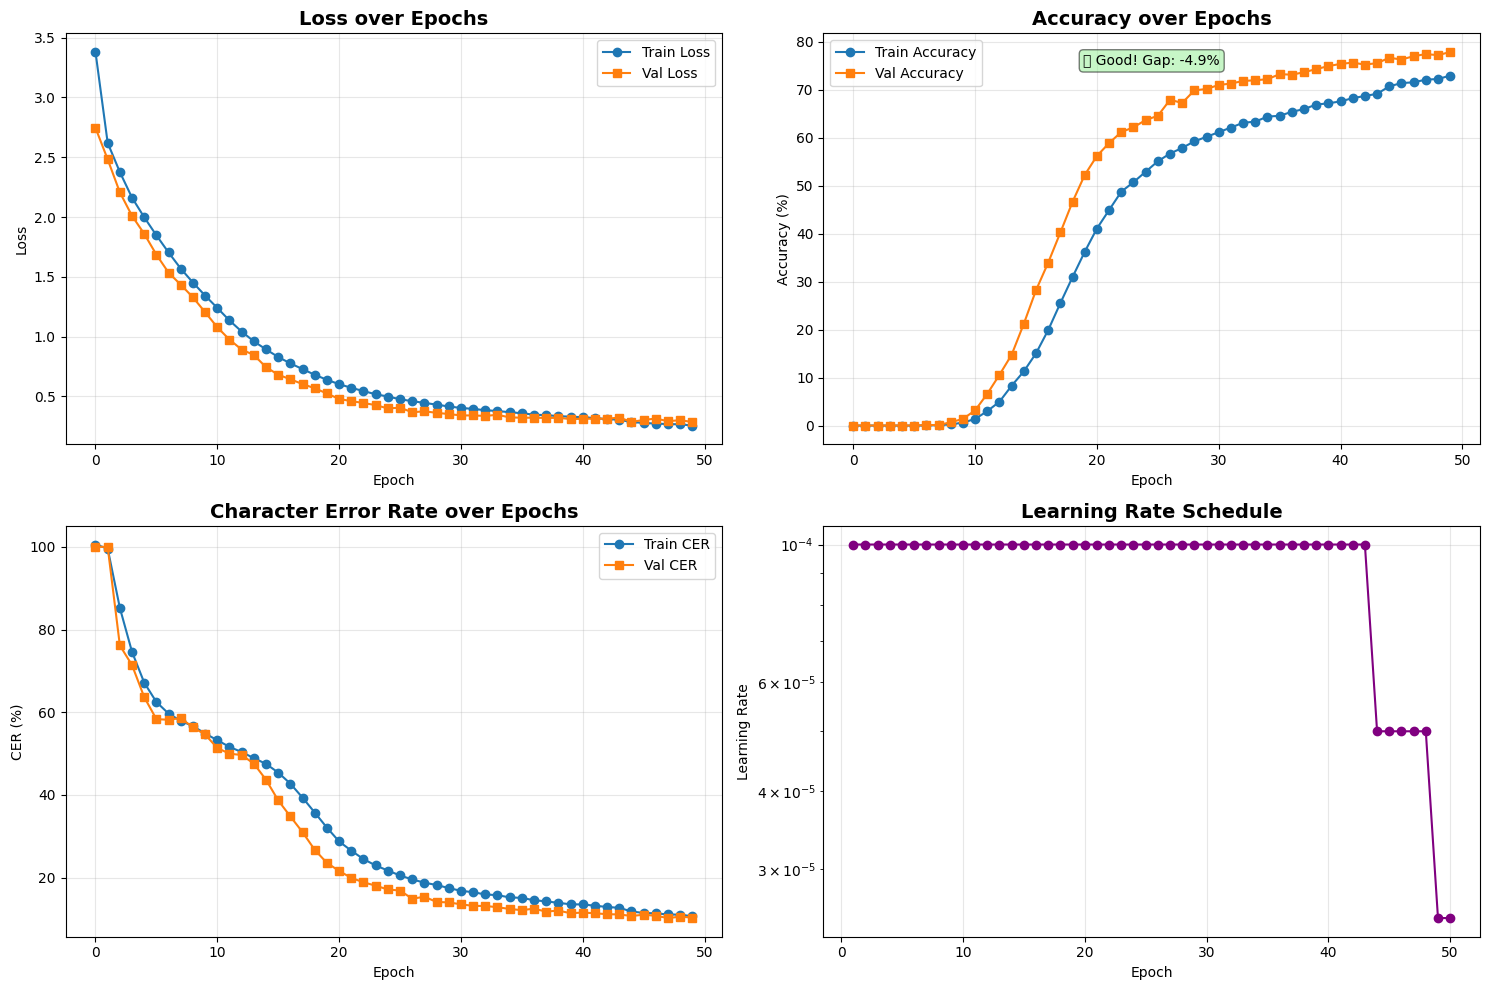


Final metrics:
Train Acc: 72.92% | Val Acc: 77.83%
Train CER: 10.66% | Val CER: 10.35%
Overfitting gap: -4.91%


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[0, 1].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

final_gap = history['train_acc'][-1] - history['val_acc'][-1]
if final_gap < 5:
    axes[0, 1].text(0.5, 0.95, f'✅ Good! Gap: {final_gap:.1f}%', 
                   transform=axes[0, 1].transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
elif final_gap > 15:
    axes[0, 1].text(0.5, 0.95, f'⚠️ Overfitting! Gap: {final_gap:.1f}%', 
                   transform=axes[0, 1].transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

axes[1, 0].plot(history['train_cer'], label='Train CER', marker='o')
axes[1, 0].plot(history['val_cer'], label='Val CER', marker='s')
axes[1, 0].set_title('Character Error Rate over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('CER (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(1, len(history['lr']) + 1), history['lr'], marker='o', color='purple')
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal metrics:")
print(f"Train Acc: {history['train_acc'][-1]:.2f}% | Val Acc: {history['val_acc'][-1]:.2f}%")
print(f"Train CER: {history['train_cer'][-1]:.2f}% | Val CER: {history['val_cer'][-1]:.2f}%")
print(f"Overfitting gap: {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")

Loaded best model from epoch 50
Val Accuracy: 77.83%
Val Loss: 0.2856


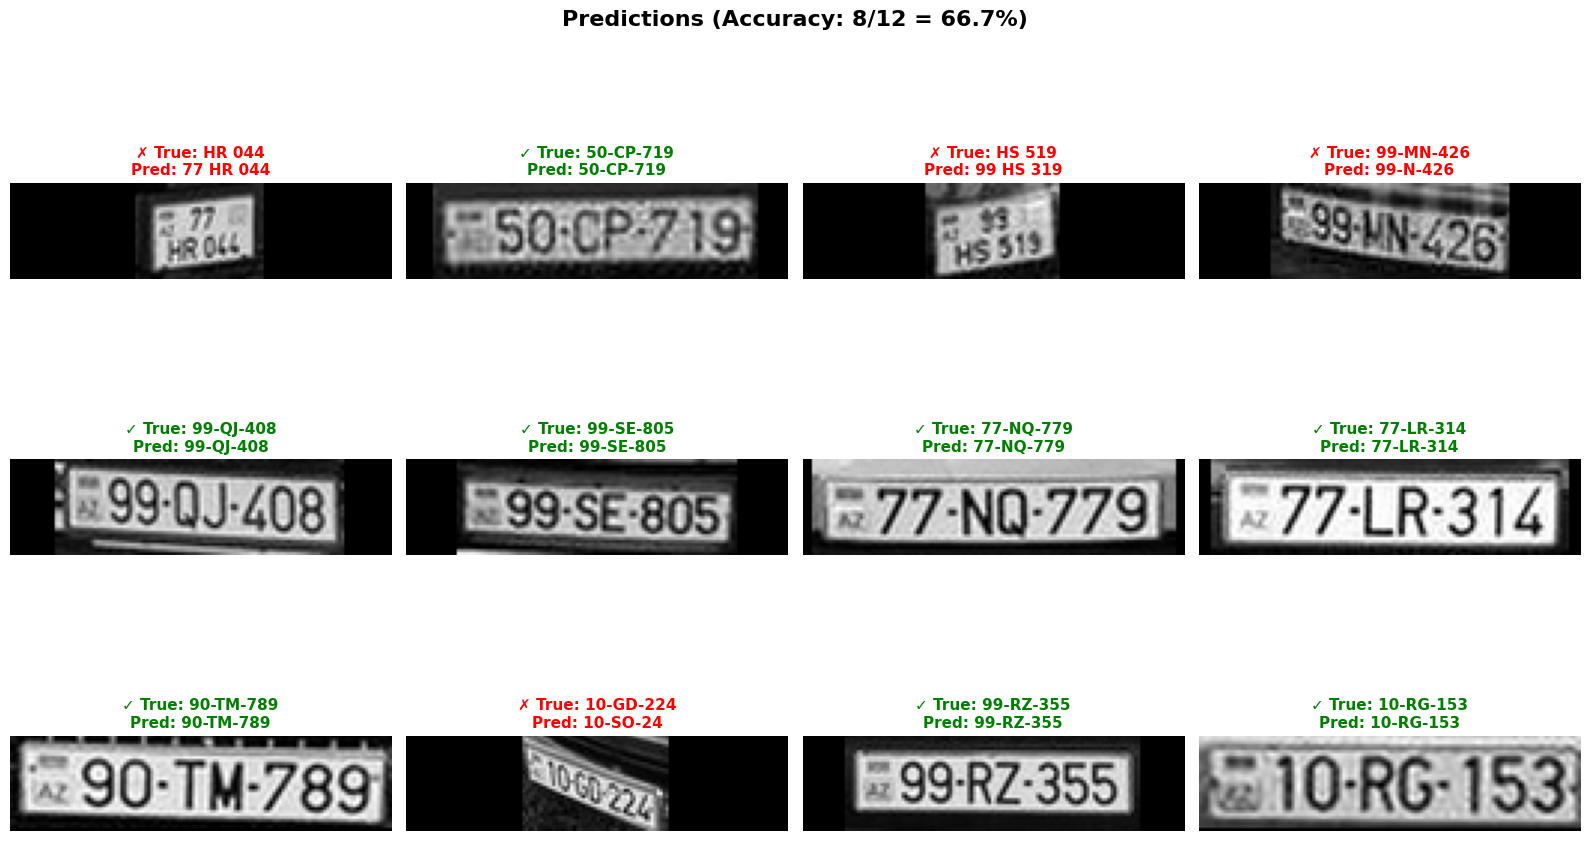

In [20]:
checkpoint = torch.load('best_model_acc.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Val Accuracy: {checkpoint['val_acc']:.2f}%")
print(f"Val Loss: {checkpoint['val_loss']:.4f}")

sample_images, sample_labels, sample_label_lengths = next(iter(val_loader))
sample_images = sample_images.to(DEVICE)

with torch.no_grad():
    outputs = model(sample_images)
    predictions = decode_predictions(outputs, BLANK_LABEL)

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

label_start = 0
correct_count = 0
for i, ax in enumerate(axes.flat):
    if i >= len(predictions):
        break
    
    img = sample_images[i].cpu().squeeze().numpy()
    img = (img * 0.5 + 0.5)
    ax.imshow(img, cmap='gray')
    
    label_end = label_start + sample_label_lengths[i]
    true_label = ''.join([idx_to_char[idx.item()] for idx in sample_labels[label_start:label_end]])
    label_start = label_end
    
    pred_label = ''.join([idx_to_char[idx] for idx in predictions[i]])
    
    is_correct = pred_label == true_label
    if is_correct:
        correct_count += 1
    
    color = 'green' if is_correct else 'red'
    symbol = '✓' if is_correct else '✗'
    ax.set_title(f"{symbol} True: {true_label}\nPred: {pred_label}", color=color, fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle(f'Predictions (Accuracy: {correct_count}/{min(12, len(predictions))} = {correct_count/min(12, len(predictions))*100:.1f}%)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
torch.save({
    'model_state_dict': model.state_dict(),
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'num_classes': NUM_CLASSES,
    'blank_label': BLANK_LABEL,
    'img_height': IMG_HEIGHT,
    'img_width': IMG_WIDTH,
    'dropout': DROPOUT
}, 'crnn_final_model.pth')

print("Final model saved as 'crnn_final_model.pth'")
print(f"\nModel configuration:")
print(f"  - Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  - Dropout: {DROPOUT}")
print(f"  - Num classes: {NUM_CLASSES}")
print(f"  - Characters: {''.join(CHARS)}")

Final model saved as 'crnn_final_model.pth'

Model configuration:
  - Image size: 32x128
  - Dropout: 0.3
  - Num classes: 66
  - Characters:  -.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZadefino·ÖÜüВГКМОРСТУмсхน모오


In [22]:
def predict_license_plate(image_path, model, device, char_to_idx, idx_to_char, blank_label):
    transform = transforms.Compose([
        ResizeWithPad(IMG_HEIGHT, IMG_WIDTH),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = decode_predictions(output, blank_label)[0]
        pred_text = ''.join([idx_to_char[idx] for idx in prediction])
    
    return pred_text

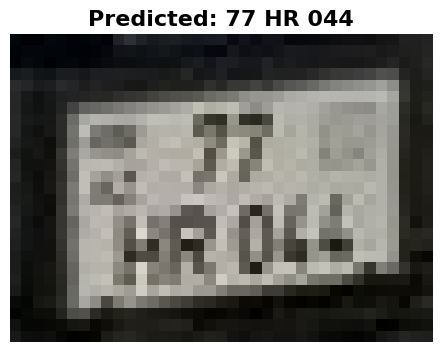

Predicted license plate: 77 HR 044


In [23]:
test_image_path = os.path.join(VAL_IMG_DIR, val_df.iloc[0]['filename'])
predicted_text = predict_license_plate(test_image_path, model, DEVICE, char_to_idx, idx_to_char, BLANK_LABEL)

img = Image.open(test_image_path)
plt.figure(figsize=(10, 4))
plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {predicted_text}", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

print(f"Predicted license plate: {predicted_text}")